In [1]:
# Necessary imports

from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

In [2]:
# Get the data

colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
# Check out the data

df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
# First thing is to clean up timestamp by removing the brackets and trailing zeroes

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [5]:
# Convert timestamp to a more pandas-friendly datetime

df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [6]:
# Make timestamp the index

df = df.set_index('timestamp')

In [7]:
# Clean up the request_method, request_agent, and destination columns

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [8]:
# Convert bytes to mb in new column

df['size_mb'] = [n/1024/1024 for n in df['size']]

In [9]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


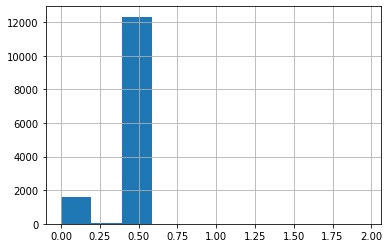

In [10]:
# A quick histogram of the size_mb distribution

df.size_mb.hist()

In [16]:
# See how many instances are above .50 mb

df[df.size_mb > .50]

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0,0.487092
...,...,...,...,...,...,...,...
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511781,NaN,python-requests/2.21.0,0.488072
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510136,NaN,python-requests/2.21.0,0.486504
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,NaN,python-requests/2.21.0,0.486532


#### Takeaway: an overwhelming majority of the data moved are reasonably-sized, only 2 instances are suspiciously large

In [13]:
# Check the status of the status

df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

#### Status meaning: 
- 200: ok
- 301: this resource has moved permanently
- 499: a token is required and still needs to be submitted to proceed

In [18]:
# Counts by ip address

df.groupby('ip').count()

,request_method,status,size,destination,request_agent,size_mb
ip,,,,,,
173.173.113.51,1059,1059,1059,0,1059,1059
24.26.242.9,21,21,21,0,21,21
3.88.129.158,1,1,1,0,1,1
3.92.201.136,1,1,1,0,1,1
34.207.64.242,1,1,1,0,1,1
34.229.70.250,1,1,1,0,1,1
35.174.209.2,1,1,1,0,1,1
35.175.171.137,2,2,2,0,2,2
45.23.250.16,1,1,1,0,1,1


#### Takeaway: we see that the majority of the requests came from just 6 ip addresses

In [19]:
# Viewing the request_agent column

df.groupby('request_agent').count()

,ip,request_method,status,size,destination,size_mb
request_agent,,,,,,
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,8,8,8,0,8
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,2,2,2,1,2
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,4,4,4,4,4
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,34,34,34,20,34
Python-urllib/3.7,1,1,1,1,0,1
Slackbot 1.0 (+https://api.slack.com/robots),6,6,6,6,0,6
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,7,7,7,0,7
python-requests/2.20.1,1911,1911,1911,1911,0,1911
python-requests/2.21.0,12005,12005,12005,12005,0,12005


#### Takeaway: the majority of the request agents were python

In [21]:
# Probability of ip addresses

ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df = ip_df.merge(ip_df2)
ip_df

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,54.145.52.184,1,0.000072


In [22]:
# Probability of request_method

req_meth_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_count'})

req_meth_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})

req_meth = req_meth_df.merge(req_meth_df2)
req_meth

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


In [23]:
# Probability of status

status_df = pd.DataFrame(df.status.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_count'})

status_df2 = pd.DataFrame(df.status.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_proba'})

status = status_df.merge(status_df2)
status

,status,status_count,status_proba
0,200,13960,0.998712
1,499,16,0.001145
2,301,2,0.000143


In [24]:
# Probabilty of destination

dest_df = pd.DataFrame(df.destination.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_count'})

dest_df2 = pd.DataFrame(df.destination.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_proba'})

dest = dest_df.merge(dest_df2)
dest

,destination,destination_count,destination_proba
0,NaN,13953,0.998211
1,https://python.zach.lol/,4,0.000286
2,https://ds.codeup.com/8.3_Acquire/,3,0.000215
3,https://python.zach.lol/api/v1/stores?page=1,2,0.000143
4,https://python.zach.lol/api/v1/,2,0.000143
5,https://python.zach.lol/api/v1/stores?page=999,1,0.000072
6,https://python.zach.lol/api/v1//api/v1/items?p...,1,0.000072
7,https://python.zach.lol/api/v1/sales?page=3,1,0.000072
8,https://python.zach.lol/api/v1//api/v1/items,1,0.000072
9,https://python.zach.lol/api/v1/helloclass!,1,0.000072


In [25]:
# Probabilty of request agent

agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_count'})

agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

agent = agent_df.merge(agent_df2)
agent

,request_agent,request_agent_count,request_agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [30]:
# Establish a baseline, check out the shape 

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

train.shape

(13974, 12)

In [31]:
# Probability of discrete/categorical occurence on train data

ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
method_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
status_df = pd.DataFrame(train.status.value_counts(dropna=False)/train.status.count()).reset_index().\
                rename(index=str, columns={'index': 'status', 'status': 'status_proba'})
destination_df = pd.DataFrame(train.destination.value_counts(dropna=False)/train.destination.count()).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_proba'})
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

In [32]:
# Merge train probability dfs with all data

df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(method_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(status_df, on=['status'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(destination_df, on=['destination'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba_x,request_method_proba_x,status_proba_x,destination_proba_x,request_agent_proba_x,ip_proba_y,request_method_proba_y,status_proba_y,destination_proba_y,request_agent_proba_y
timestamp,,,,,,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.887577,0.998855,0.0,0.858809,0.858595,0.887577,0.998855,0.998211,0.858809
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.076213,0.998855,0.0,0.858809,0.858595,0.076213,0.998855,0.998211,0.858809
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.887577,0.998855,0.0,0.858809,0.858595,0.887577,0.998855,0.998211,0.858809
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.887577,0.998855,0.0,0.858809,0.858595,0.887577,0.998855,0.998211,0.858809
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.887577,0.998855,0.0,0.858809,0.858595,0.887577,0.998855,0.998211,0.858809
